In [ ]:
import numpy as cp
import numpy as np
from scipy.optimize import minimize

import matplotlib.pyplot as plt



def valor_absoluto(x):
    if x > 0:
        return x
    return -x

def maximo(x):
    if x > 0:
        return x
    return np.float64(0)



def moreau_yosida_transform(f, x, lambda_):
    # Definir la función objetivo para la minimización
    if type(x)==cupy.ndarray:
        X=x.get()
    else:
        X=x
    def objective(y):
        return f(y) + (1 / (2 * lambda_)) * np.linalg.norm(X - y)**2
    # Minimizar la función objetivo
    result = minimize(objective, X, method='BFGS')

    # Devolver el valor minimizado de la función objetivo
    return cp.array(result.fun)

def grad_moreau_yosida_transform(f, x, lambda_):
    if type(x)==cupy.ndarray:
        X=x.get()
    else:
        X=x
    # Definir la función objetivo para la minimización
    def objective(y):
        return f(y) + (1 / (2 * lambda_)) * np.linalg.norm(X - y)**2
    # Minimizar la función objetivo aun si x es matriz

    result = minimize(objective, X, method='BFGS')
    p=result.x
    # Devolver el resultado de la minimización en cupy
    return cp.array((X-p)/lambda_)


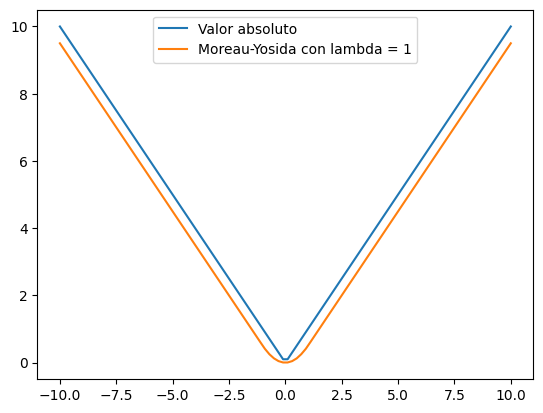

In [ ]:
# grafica con la función valor absoluto en mabos casos
x = np.linspace(-10, 10, 100)
y = [valor_absoluto(i) for i in x]


plt.plot(x, y, label='Valor absoluto')

# grafica con la función Moreau-Yosida en ambos casos
X = cp.linspace(-10, 10, 100)
y = [moreau_yosida_transform(valor_absoluto, i, 1) for i in X]
y=cp.array(y)
# y=y.get()

plt.plot(x, y, label='Moreau-Yosida con lambda = 1')

plt.legend()

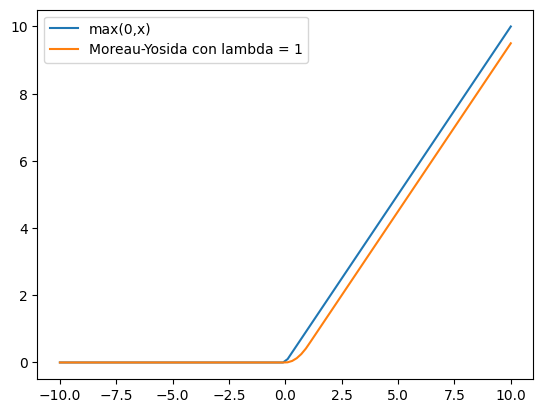

In [ ]:
# grafica con la función valor absoluto en mabos casos
x = np.linspace(-10, 10, 100)
y = [maximo(i) for i in x]
plt.plot(x, y, label='max(0,x)')

# grafica con la función Moreau-Yosida en ambos casos
X = cp.linspace(-10, 10, 100)
y = [moreau_yosida_transform(maximo, i, 1) for i in X]
y=cp.array(y)
# y=y.get()

plt.plot(x, y, label='Moreau-Yosida con lambda = 1')

plt.legend()



# Implementación del gradiente conjugado robusto propuesto

In [ ]:
def gradient_conjugate_robust(F, grad_F, f,  x0, lambd, gamma, sigma, c, epsilon):

    x_k = x0
    g_k = grad_F(f,x_k, lambd)
    d_k = -g_k
    #Crear un archivo txt para guardar los datos
    archivo = open("datos.txt", "w")

    for i in range(1000):
        g_knorm = cp.linalg.norm(g_k)
        print(i, g_knorm)
        if g_knorm  <= epsilon:
            break
        # Encontrar alpha_k que minimice F(x_k + alpha_k * d_k) con la condición de Armijo
        alpha_k = 1.0
        while F(f, x_k + alpha_k * d_k, lambd) > F(f,x_k, lambd) + sigma * alpha_k * cp.dot(g_k, d_k):
            alpha_k *= c

        # Actualizar x_{k+1}
        x_k1 = x_k + alpha_k * d_k

        #Escribir x_k1 en el archivo
        archivo.write(str(x_k1))
        archivo.write("\n")





        # Calcular el nuevo gradiente
        g_k1 = grad_F(f,x_k1, lambd)

        # Calcular s_k y y_k
        s_k = x_k1 - x_k
        y_k = g_k1 - g_k
        y_knorm = cp.linalg.norm(y_k)
        s_knorm = cp.linalg.norm(s_k)
        d_knorm = cp.linalg.norm(d_k)


        t=alpha_k
        lastnumerador = (1+t**2) * y_knorm**2*(cp.dot(d_k,g_k1))
        lastdenominador=4*c*((1+t**2)*y_k-t*s_k).T@g_k1

        if lastdenominador==0:
            last=0
        else:
            last=lastnumerador/lastdenominador

        T_k = max(gamma*d_knorm*y_knorm, d_knorm*s_knorm, cp.abs(cp.dot(d_k, y_k)),  last)
        beta_k = (y_k-((y_knorm**2)/(4*c))*((d_k)/(T_k))-((t)/(1+t**2))*s_k).T*g_k1/T_k

        # Actualizar la dirección de búsqueda
        d_k = -g_k1 + beta_k * d_k

        # Preparar para la siguiente iteración
        x_k = x_k1
        g_k = g_k1
    print("Iteraciones:", i+1)
    print("||g_k||:", g_knorm)

    return x_k



# Ejemplos con funciones mostradas anteriormente

In [ ]:
x0 = cp.array([3.0])
lambd = 1.0
gamma = 0.9
sigma = 0.1
c = 0.5
epsilon = 1e-20

In [ ]:
solution = gradient_conjugate_robust(moreau_yosida_transform, grad_moreau_yosida_transform, valor_absoluto, x0, lambd, gamma, sigma, c, epsilon)
print("Solución:", solution)

0 1.0
1 1.0
2 0.5000000031798418
3 0.11111110802538259
4 3.822914915203912e-10
5 0.0
Iteraciones: 6
||g_k||: 0.0
Solución: [-7.29654187e-09]


In [ ]:
solution = gradient_conjugate_robust(moreau_yosida_transform, grad_moreau_yosida_transform, maximo, x0, lambd, gamma, sigma, c, epsilon)
print("Solución:", solution)

0 1.0
1 1.0
2 0.500000002444218
3 0.0
Iteraciones: 4
||g_k||: 0.0
Solución: [-0.11111111]


# Prueba con imágenes


# Acondicionamiento de la foto

In [ ]:
#importar imagenes
from PIL import Image
#Disminuir la resolución de la imagen
s=20
image = Image.open('Imagen.png')
image = image.resize((s, s))
image.save('Imagen_resized.png')

# Convertir la imagen a un arreglo de numpy
image = np.array(image)

#Convertir image en blanco y negro
imagen=np.ndarray((s,s))
for i in range(len(image)):
    for j in range(len(image[0])):
        imagen[i][j]=image[i][j][1]
#invertir color
for i in range(len(image)):
    for j in range(len(image[0])):
        imagen[i][j]=256-imagen[i][j]



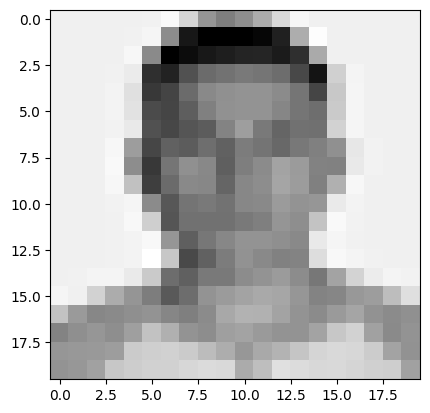

In [ ]:
import scipy.linalg as la
plt.set_cmap('binary')
N = s
Z = np.zeros((N//4,N//4))
O = np.ones((N//4,N//4))
X = np.block([[Z,Z,Z,Z],[Z,O,O,Z],[Z,O,O,Z],[Z,Z,Z,Z]])
plt.imshow(imagen)
plt.show()

# Creación de matriz Toeplitz para desenfoque con $s$ pixeles

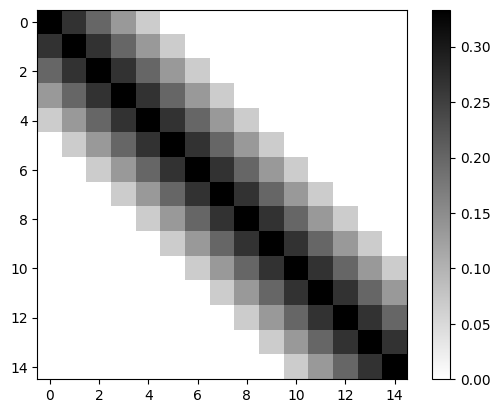

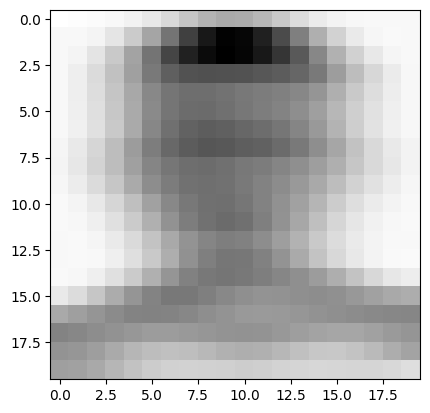

In [ ]:
c = np.zeros(N**2)
p = 5
c[:p] = (p - np.arange(0,p))/(3*p)
Ac = la.toeplitz(c)
plt.imshow(Ac[:15,:15])
plt.colorbar()
plt.show()


X=imagen.flatten()
Y=Ac@X

foto=Y.reshape((s,s))

plt.imshow(foto)
plt.show()

# Restauración de imagen

In [ ]:
#definimos la función a minimizar
nu=0.01
def imageRepair(x):
    A1=(Ac@x)-Y
    A=(1/2)*np.linalg.norm(A1)**2
    return A+nu*np.linalg.norm(x, 1)

# Leemos el último $x_k$ calculado

In [ ]:
#leer x0 de datos.txt y convertirmo en un array de numpy donde los datos están separados porespacios
# Paso 1: Abrir el archivo para leer
with open('datos.txt', 'r') as file:
    # Paso 2: Leer el contenido del archivo
    data = file.read()

# Paso 3: Limpiar el contenido del archivo
data = data.replace('[', '').replace(']', '').replace('\n', ' ')

# Paso 4: Dividir la cadena en elementos individuales y convertirlos a números
lista = [float(num) for num in data.split()]

# Imprimir la lista para verificar
x0=np.array(lista)

print(len(x0))


400


# Continuar reconstrucción desde el último $x_k$

In [ ]:
#x0 = Y

print(x0)
lambd = 1.0
gamma = 0.9
sigma = 0.1
c = 0.5
epsilon = 1e-20
solution = gradient_conjugate_robust(moreau_yosida_transform, grad_moreau_yosida_transform, imageRepair, x0, lambd, gamma, sigma, c, epsilon)

[ 9.72620853e+00  2.01229217e+01  2.19690185e+01  1.53619855e+01
  1.16312193e+01  7.44235516e+00  1.24920899e+01  5.19535620e+01
  1.05353312e+02  1.22506416e+02  1.10683945e+02  8.86524743e+01
  4.53832607e+01  7.04149259e+00  9.73643366e+00  2.01735498e+01
  1.78775122e+01  1.39003243e+01  1.29322613e+01  1.53267838e+01
  2.84913965e+01  1.35363402e+01  6.80542752e-01  1.63467964e+01
  2.32874435e+01  2.74593966e+01  1.09645039e+02  2.04632297e+02
  2.61349122e+02  2.74839824e+02  2.67589062e+02  2.40525621e+02
  1.90328568e+02  8.94611997e+01  3.21883169e+01  2.33184868e+01
  8.09225470e-01 -7.89529972e+00  1.62917216e+01  4.83499940e+01
  2.28424424e+01 -2.69066026e+00 -8.33425551e-05  1.09025471e+01
  3.79573346e+01  1.31378786e+02  2.33410815e+02  2.31519117e+02
  2.24830581e+02  2.50929908e+02  2.35192053e+02  1.98660193e+02
  2.16051824e+02  2.04063086e+02  1.10246267e+02  2.37209800e+01
  1.76524414e+00  6.18228462e+00  1.07229765e+01  4.15838277e+01
  9.60671392e+00  9.09303

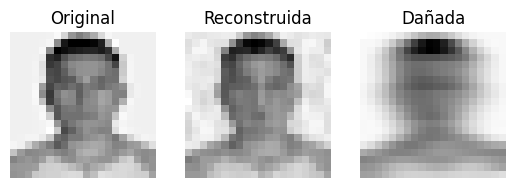

In [ ]:
#Convertir imagen a numpy
#solution=solution.get()
solution=x0

#reconstriur imagen
fotorec=solution.reshape((s,s))
#plotear la foto junto a la original y la que se tenía en subplots
plt.subplot(1, 3, 1)
plt.imshow(imagen)
plt.title('Original')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(fotorec)
plt.title('Reconstruida')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(foto)
plt.title('Dañada')
plt.axis('off')
plt.show()





# Comportamiento del gradiente a lo largo de las iteraciones

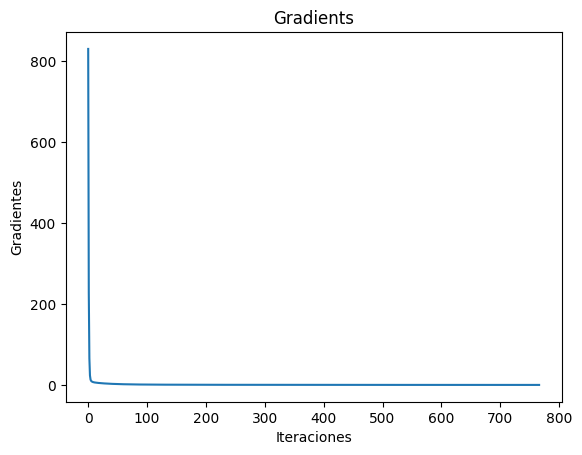

In [ ]:
#Leemos el archivo llamado gradientes.txt
# Paso 1: Abrir el archivo para leer
with open('Gradientes.txt', 'r') as file:
    # Paso 2: Leer el contenido del archivo
    data = file.read()
grads=[]
#leemos linea por linea y borramos el primer numero y el segundo lo metemos a grads
for line in data.split('\n'):
    if line:
        grads.append(float(line.split(' ')[1]))
#convertimos grads en un array de numpy
grads=np.array(grads)

plt.plot(grads)
plt.title('Gradients')
plt.xlabel('Iteraciones')
plt.ylabel('Gradientes')
plt.show()